# Pylops - Least squares migration - old vs new

### Author: M.Ravasi

Here we compare the old and new Kirchhoff... the main difference arises from the fact we introduced `_wavelet_reshaping` (need to choose if we want allow this to be optional...)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from kirchhoff_old import _traveltime_table, KirchhoffOLD

## 2D layered in homogenous velocity

Lets' create a model and geometry

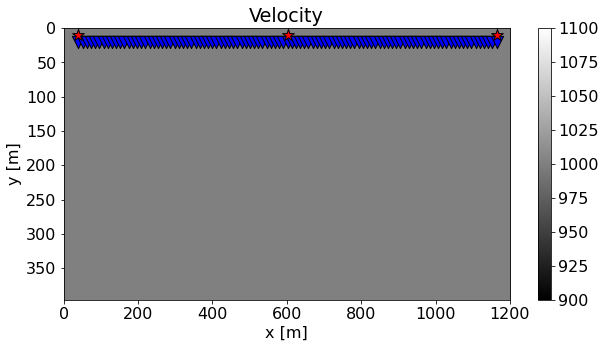

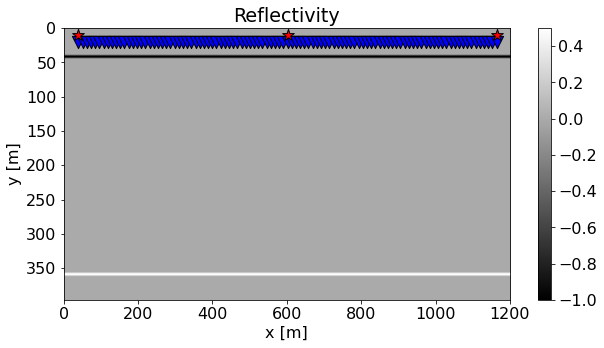

In [2]:
# Velocity Model
nx, nz = 301, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
#refl[nx//2, 50] = -1
refl[:, 10] = -1
refl[:, -10] = 0.5

# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 3
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
#ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

Compute traveltimes for homogenous medium

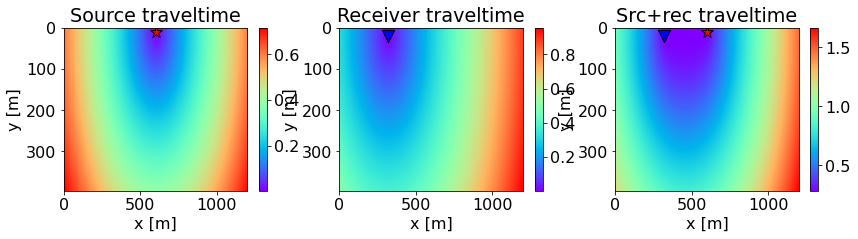

In [3]:
trav, trav_srcs, trav_recs = _traveltime_table(z, x, sources, recs, v0, mode='analytic')

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

Let's do the same using an eikonal solver

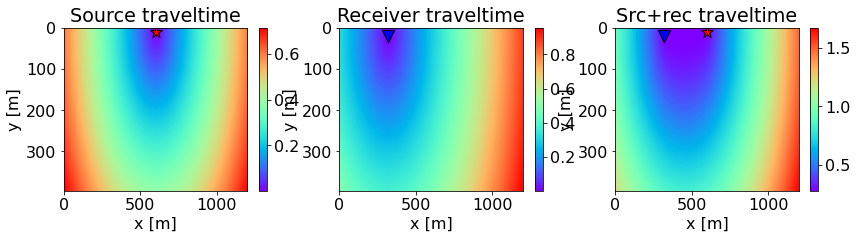

In [4]:
trav_eik, trav_srcs_eik, trav_recs_eik = _traveltime_table(z, x, sources, recs, vel, mode='eikonal')

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs_eik[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs_eik[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav_eik[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

Finally we model the data and invert it

In [5]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

In [6]:
kop = KirchhoffOLD(z, x, t, sources, recs, v0, wav, wavc, trav=trav, mode='analytic')
kop1 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', engine='numba')

Done
Done1


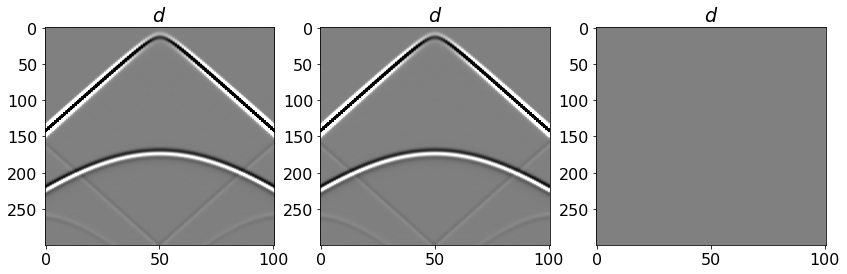

In [7]:
d = kop * refl.ravel()
d = d.reshape(ns, nr, nt)
print('Done')

d1 = kop1 * refl.ravel()
d1 = d1.reshape(ns, nr, nt)
print('Done1')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d1[ns//2, :, :300].T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$d$')
axs[1].axis('tight')
axs[2].imshow(d[ns//2, :, :300].T - d1[ns//2, :, :300].T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$d$')
axs[2].axis('tight');

In [8]:
np.allclose(d,d1)

True

Done
Done1


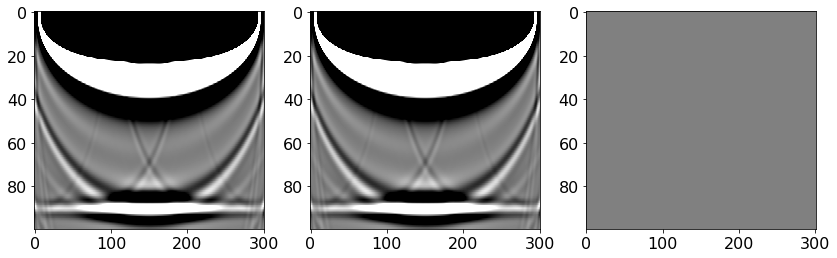

In [9]:
madj = kop.H * d.ravel()
madj = madj.reshape(nx, nz)
print('Done')

madj1 = kop1.H * d.ravel()
madj1 = madj1.reshape(nx, nz)
print('Done1')

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(madj.T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[0].axis('tight')
axs[1].imshow(madj1.T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[1].axis('tight')
axs[2].imshow(madj.T-madj1.T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[2].axis('tight');

In [10]:
np.allclose(madj,madj1)

True

In [11]:
dottest(kop1, verb=True)

Dot test passed, v^H(Opu)=-4001.7129599326227 - u^H(Op^Hv)=-4001.7129599326245


True

In [12]:
%timeit -n10 -r3 kop.matvec(refl.ravel())
%timeit -n10 -r3 kop1.matvec(refl.ravel())

15.4 ms ± 423 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
24.2 ms ± 283 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [13]:
%timeit -n10 -r3 kop.H * d.ravel()
%timeit -n10 -r3 kop1.H * d1.ravel()

6.17 ms ± 695 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
11.9 ms ± 673 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [14]:
%prun kop.matvec(refl.ravel())

In [15]:
%prun kop1.matvec(refl.ravel())